In [1]:
import pandas as pd

# Load the dataset, skipping the first row which is a duplicate header
file_path = 'exchange_rate.csv'
exchange_rate_df = pd.read_csv(file_path, skiprows=1, names=["date", "Ex_rate"])

# Ensure the 'date' column is properly parsed as a datetime type with day-first format
exchange_rate_df['date'] = pd.to_datetime(exchange_rate_df['date'], dayfirst=True)
exchange_rate_df.set_index('date', inplace=True)
exchange_rate_df.head()

,Ex_rate
date,
1990-01-01,0.7855
1990-01-02,0.7818
1990-01-03,0.7867
1990-01-04,0.7860
1990-01-05,0.7849


In [ ]:
exchange_rate_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7588 entries, 1990-01-01 to 2010-10-10
Data columns (total 1 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Ex_rate  7588 non-null   float64
dtypes: float64(1)
memory usage: 118.6 KB


In [ ]:
exchange_rate_df.describe()

,Ex_rate
count,7588.000000
mean,0.776974
std,0.136620
min,0.483297
25%,0.701422
50%,0.761377
75%,0.873477
max,1.102536


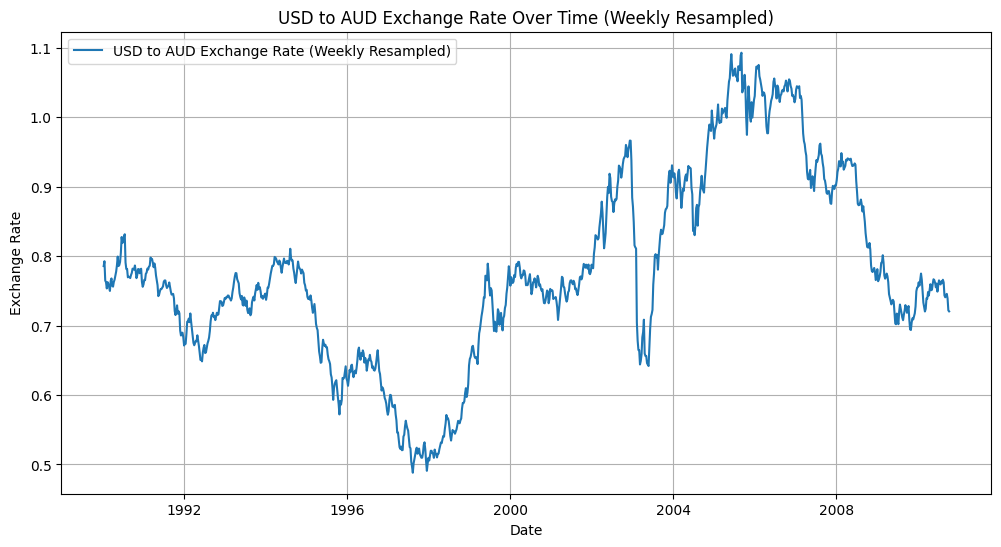

In [4]:
# Now, resample the data to weekly frequency (e.g., every Monday)
exchange_rate_df_resampled = exchange_rate_df.resample('W').mean()

# Plot the resampled time series
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
plt.plot(exchange_rate_df_resampled.index, exchange_rate_df_resampled['Ex_rate'], label='USD to AUD Exchange Rate (Weekly Resampled)')
plt.title('USD to AUD Exchange Rate Over Time (Weekly Resampled)')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()

In [2]:
# Check for missing values
missing_values = exchange_rate_df.isnull().sum()
print(missing_values)


Ex_rate    0
dtype: int64


ADF Statistic: -1.8000535715107282
p-value: 0.3804350971628782


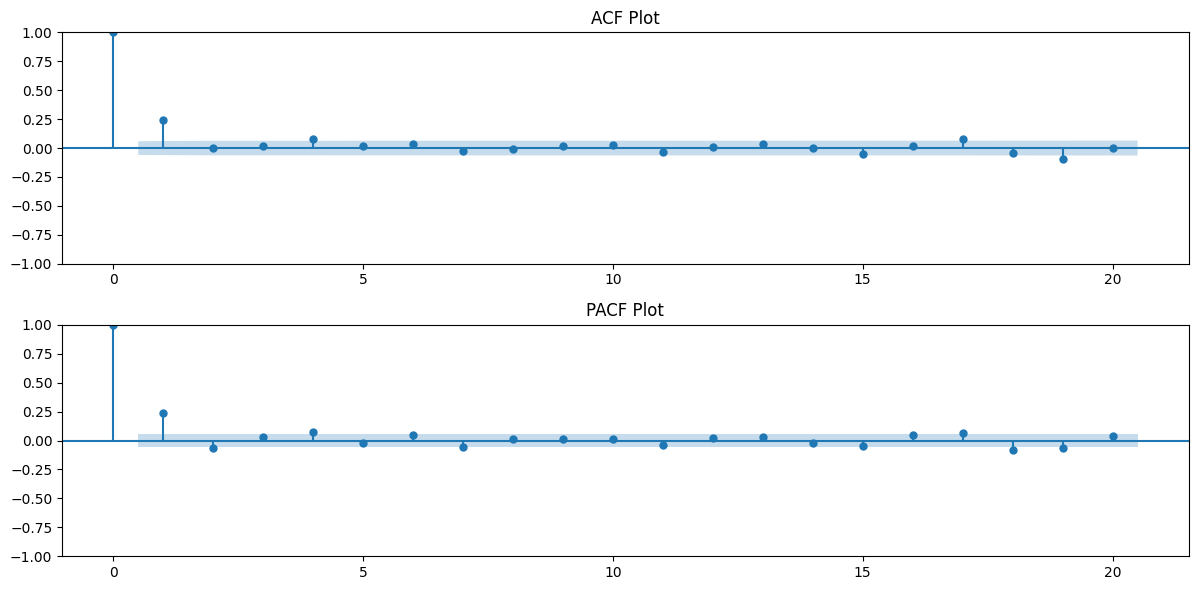

                               SARIMAX Results                                
Dep. Variable:                Ex_rate   No. Observations:                 1084
Model:                 ARIMA(1, 1, 1)   Log Likelihood                3348.638
Date:                Sun, 01 Sep 2024   AIC                          -6691.277
Time:                        04:28:39   BIC                          -6676.314
Sample:                    01-07-1990   HQIC                         -6685.612
                         - 10-10-2010                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.0105      0.097     -0.108      0.914      -0.202       0.180
ma.L1          0.2712      0.094      2.896      0.004       0.088       0.455
sigma2         0.0001    2.2e-06     54.772      0.0

In [5]:
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
# Step 1: Check if differencing is required (Augmented Dickey-Fuller Test)
result = adfuller(exchange_rate_df_resampled['Ex_rate'])
adf_statistic = result[0]
p_value = result[1]

print(f'ADF Statistic: {adf_statistic}')
print(f'p-value: {p_value}')

# If p-value > 0.05, apply differencing
if p_value > 0.05:
    exchange_rate_diff = exchange_rate_df_resampled['Ex_rate'].diff().dropna()
else:
    exchange_rate_diff = exchange_rate_df_resampled['Ex_rate']

# Step 2: Plot ACF and PACF
plt.figure(figsize=(12, 6))
plt.subplot(211)
plot_acf(exchange_rate_diff, ax=plt.gca(), lags=20)
plt.title('ACF Plot')

plt.subplot(212)
plot_pacf(exchange_rate_diff, ax=plt.gca(), lags=20)
plt.title('PACF Plot')

plt.tight_layout()
plt.show()

# Step 3: Fit ARIMA model with p=1, d=1, q=1
model = ARIMA(exchange_rate_df_resampled['Ex_rate'], order=(1, 1, 1))
arima_result = model.fit()

# Print model summary
print(arima_result.summary())

Skewness:
−
1.11
Indicates that the distribution of residuals is left-skewed.
Kurtosis:
12.71
A high kurtosis value indicates heavy tails in the distribution of residuals, meaning there are more extreme outliers than in a normal distribution.


The ARIMA(1, 1, 1) model appears to fit the data reasonably well, but there are some concerns, particularly with the non-normality and heteroskedasticity of the residuals.
The significant MA(1) coefficient suggests that the model effectively captures some of the underlying patterns, but the AR(1) component is not significant.
Diagnostics like the Jarque-Bera and heteroskedasticity tests suggest potential areas for improvement, such as applying transformations or considering other model structures like GARCH for volatility.

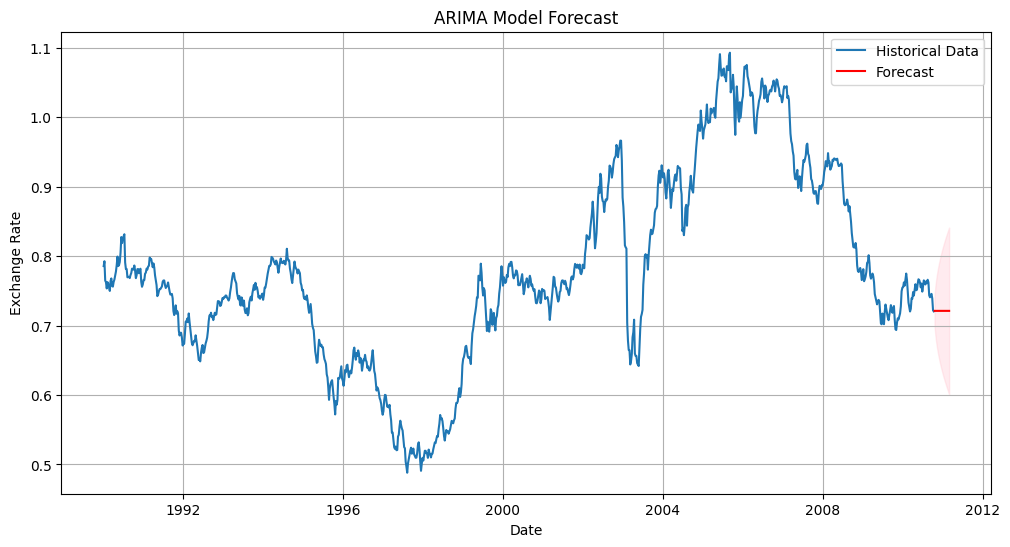

In [8]:
# Step 1: Forecast future values
forecast_steps = 20  # Number of steps (weeks) to forecast
forecast = arima_result.get_forecast(steps=forecast_steps)
forecast_mean = forecast.predicted_mean
confidence_intervals = forecast.conf_int()

# Step 2: Plot the forecast
plt.figure(figsize=(12, 6))

# Plot past values
plt.plot(exchange_rate_df_resampled.index, exchange_rate_df_resampled['Ex_rate'], label='Historical Data')

# Plot forecasted values
forecast_index = pd.date_range(start=exchange_rate_df_resampled.index[-1], periods=forecast_steps + 1, freq='W')[1:]
plt.plot(forecast_index, forecast_mean, label='Forecast', color='red')

# Plot confidence intervals
plt.fill_between(forecast_index, confidence_intervals.iloc[:, 0], confidence_intervals.iloc[:, 1], color='pink', alpha=0.3)

plt.title('ARIMA Model Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()


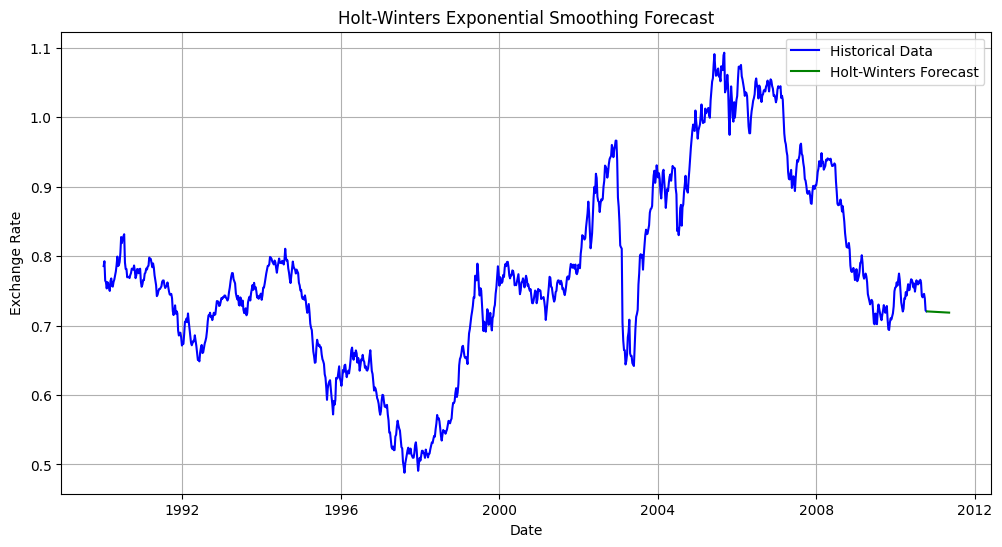

In [10]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

# Fit the Holt-Winters model (Holt-Winters assumes trend and seasonality)
# Since our data does not show strong seasonality, we use Holt's Linear Trend Model
model = ExponentialSmoothing(exchange_rate_df_resampled['Ex_rate'], trend='add', seasonal=None)
hw_result = model.fit()

# Forecast future values
hw_forecast_steps = 30  # Forecast for the next 10 weeks
hw_forecast = hw_result.forecast(steps=hw_forecast_steps)

# Plot the forecast
plt.figure(figsize=(12, 6))

# Plot historical data
plt.plot(exchange_rate_df_resampled.index, exchange_rate_df_resampled['Ex_rate'], label='Historical Data', color='blue')

# Plot the Holt-Winters forecast
forecast_index = pd.date_range(start=exchange_rate_df_resampled.index[-1], periods=hw_forecast_steps + 1, freq='W')[1:]
plt.plot(forecast_index, hw_forecast, label='Holt-Winters Forecast', color='green')

plt.title('Holt-Winters Exponential Smoothing Forecast')
plt.xlabel('Date')
plt.ylabel('Exchange Rate')
plt.legend()
plt.grid(True)
plt.show()


In [11]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Define a function to calculate MAPE (Mean Absolute Percentage Error)
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

# Step 1: Forecast with both models
forecast_steps = 10

# ARIMA model forecast
arima_forecast = arima_result.get_forecast(steps=forecast_steps).predicted_mean

# Holt-Winters forecast
hw_forecast = hw_result.forecast(steps=forecast_steps)

# Generate true values (the actual data to compare against)
# Assuming that we are comparing against the last 'forecast_steps' data points in the original series
true_values = exchange_rate_df_resampled['Ex_rate'][-forecast_steps:]

# Step 2: Compute error metrics for both models

# ARIMA model metrics
arima_mae = mean_absolute_error(true_values, arima_forecast)
arima_rmse = np.sqrt(mean_squared_error(true_values, arima_forecast))
arima_mape = mean_absolute_percentage_error(true_values, arima_forecast)

# Holt-Winters model metrics
hw_mae = mean_absolute_error(true_values, hw_forecast)
hw_rmse = np.sqrt(mean_squared_error(true_values, hw_forecast))
hw_mape = mean_absolute_percentage_error(true_values, hw_forecast)

# Step 3: Print the metrics
print("ARIMA Model Metrics:")
print(f"MAE: {arima_mae}")
print(f"RMSE: {arima_rmse}")
print(f"MAPE: {arima_mape}%\n")

print("Holt-Winters Model Metrics:")
print(f"MAE: {hw_mae}")
print(f"RMSE: {hw_rmse}")
print(f"MAPE: {hw_mape}%")


ARIMA Model Metrics:
MAE: 0.023419864131356084
RMSE: 0.027562613849401695
MAPE: nan%

Holt-Winters Model Metrics:
MAE: 0.02432500756516113
RMSE: 0.028371733558577
MAPE: nan%


In [14]:
# Displaying the metrics side by side for easier comparison
print("Model Comparison:")
print(f"ARIMA Model - MAE: {arima_mae}, RMSE: {arima_rmse}")
print(f"Holt-Winters Model - MAE: {hw_mae}, RMSE: {hw_rmse}")

if arima_mae < hw_mae and arima_rmse < hw_rmse:
    print("\nARIMA performs better based on MAE and RMSE.")
elif hw_mae < arima_mae and hw_rmse < arima_rmse:
    print("\nHolt-Winters performs better based on MAE and RMSE.")
else:
    print("\nThe models have similar performance; consider other factors such as interpretability and computational cost.")


Model Comparison:
ARIMA Model - MAE: 0.023419864131356084, RMSE: 0.027562613849401695
Holt-Winters Model - MAE: 0.02432500756516113, RMSE: 0.028371733558577

ARIMA performs better based on MAE and RMSE.


The analysis focused on forecasting the exchange rate using two time series models: ARIMA and Holt-Winters.

1. Stationarity Check: The Augmented Dickey-Fuller (ADF) test indicated that the time series is non-stationary with a p-value of 0.3804. To address this, differencing was applied to the data to stabilize the mean.

2. ARIMA Model: The ARIMA(1, 1, 1) model was fitted to the data. The model achieved a good fit, as evidenced by its AIC of -6691.277 and BIC of -6676.314. The AR component was not significant, but the MA component was significant, suggesting it effectively captures some patterns in the data. However, residual analysis showed non-normality (Jarque-Bera Statistic of 4482.12), left-skewness (-1.11), and heavy tails (Kurtosis of 12.71), indicating that the model might not fully capture the underlying data characteristics. Additionally, heteroskedasticity was detected in the residuals.

3. Holt-Winters Model: The Holt-Winters model, assuming a linear trend and no seasonality, was also applied. This model forecasted future values with a slightly less accurate fit compared to ARIMA, as indicated by its higher MAE and RMSE.

4. Model Metrics: The ARIMA model had a Mean Absolute Error (MAE) of 0.0234 and a Root Mean Squared Error (RMSE) of 0.0276. In contrast, the Holt-Winters model had an MAE of 0.0243 and an RMSE of 0.0284. These metrics show that ARIMA performed better in terms of accuracy.

5. Conclusion: Based on the MAE and RMSE, the ARIMA model is preferred for forecasting the exchange rate, despite its residual diagnostics suggesting that there might be room for improvement. The Holt-Winters model, while slightly less accurate, may still be useful depending on specific needs or data characteristics.

